In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.util import random_noise
import multiprocessing as mp
import os
import cv2
import random

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
print(torch.cuda.is_available())

True


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
proto_txt_path=r"/content/drive/MyDrive/SmartGlasses_BITS/deploy.prototxt"
weight_caffemodel_path=r"/content/drive/MyDrive/SmartGlasses_BITS/weights.caffemodel"

In [ ]:
model = cv2.dnn.readNetFromCaffe(proto_txt_path, weight_caffemodel_path)

In [ ]:
#Create cropped images
def data_create(image_directory_path):
    classes= os.listdir(image_directory_path)
    for item in classes:
        images = os.listdir(image_directory_path + item + '/')
        for img in images:
            image_directory_name=img
            image = cv2.resize(
                cv2.imread(image_directory_path + item + '/' + img),
                (300,300)
                )
            (h, w) = image.shape[:2]
            blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
            model.setInput(blob)
            detections = model.forward()
            # Create frame around face
            for t in range(0, detections.shape[2]):
              box = detections[0, 0, t, 3:7] * np.array([w, h, w, h])
              (startX, startY, endX, endY) = box.astype("int")

              confidence = detections[0, 0, t, 2]
              '''
              # If confidence > 0.75, show box around face
              if (confidence > 0.75):
                cv2.rectangle(image, (startX, startY), (endX, endY), (255, 255, 255), 2)


            print("Image " + file + " converted successfully")
            '''
              if (confidence>0.5):
                frame = image[startY:endY, startX:endX]
                noise_img = random_noise(frame, mode='gaussian', var=0.05)
                gaussian_noise_img = (255*noise_img).astype(np.uint8)
                speckle_noise_img = random_noise(frame, mode='speckle')
                speckle_noise_img = (255*speckle_noise_img).astype(np.uint8)
                x=random.randint(0,15)
                rotated_image=ndimage.rotate(frame,x)
                sp_noise_img = random_noise(frame, mode='s&p')
                sp_noise_img = (255*sp_noise_img).astype(np.uint8)
                frame=cv2.resize(frame,(256,256))
                gaussian_noise_img=cv2.resize(gaussian_noise_img,(256,256))
                speckle_noise_img=cv2.resize(speckle_noise_img,(256,256))
                rotated_image=cv2.resize(rotated_image,(256,256))
                sp_noise_img= cv2.resize(sp_noise_img,(256,256))
        
                savefile_common=r"/content/drive/MyDrive/Smart_Glasses/Few_Shot_Cropped_Data/"+item+"/"+img
                cv2.imwrite(savefile_common+'_0.jpg',frame)
                cv2.imwrite(savefile_common+'_gaussian.jpg',gaussian_noise_img)
                cv2.imwrite(savefile_common+'_speckle_noise.jpg',speckle_noise_img)
                cv2.imwrite(savefile_common+'_rotated.jpg',rotated_image)
                cv2.imwrite(savefile_common+'_spnoise.jpg',sp_noise_img)
                

In [ ]:
data_create(r"/content/drive/MyDrive/Smart_Glasses/Few_Shot_Learning_Data/")

In [4]:
def read_images(image_directory_path):
    """
    Reads all the images from a given directory
    Also, extract only the faces from the images and then train the model
    """
    datax = []
    datay = []
    classes= os.listdir(image_directory_path)
    for item in classes:
        images = os.listdir(image_directory_path + item + '/')
        for img in images:
            image_directory_name=img
            image = cv2.resize(cv2.imread(image_directory_path + item + '/' + img),(256,256))    
            datax.append(image)
            datay.append(image_directory_path + item + '/' + img)
    return np.array(datax), np.array(datay)         

In [5]:
image_directory_path=r"/content/drive/MyDrive/Smart_Glasses/Few_Shot_Cropped_Data/"
trainx,trainy=read_images(image_directory_path=image_directory_path)

In [6]:
classes=os.listdir(r"/content/drive/MyDrive/Smart_Glasses/Few_Shot_Cropped_Data")

In [7]:
classes

['Aamir',
 'Amitabh',
 'Andre',
 'Anushka',
 'Emilia',
 'Iain',
 'Jenna',
 'Mindy',
 'Shabana',
 'Sidhu']

In [8]:
trainx.shape

(100, 256, 256, 3)

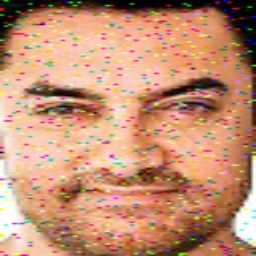

In [9]:
from google.colab.patches import cv2_imshow
cv2_imshow(trainx[4])

In [10]:
def extract_sample(n_way, n_support, n_query, datax, datay):
  """
  Picks random sample of size n_support+n_querry, for n_way classes
  Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
  Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support+n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
  """
  sample = []
  K = np.random.choice(classes, n_way, replace=False)
  locations={}
  for item in K:
    locations[item]=[]
    l=[]
    for i in trainy:
      if item in i:
        l+=[i]
    #print(l)
    
    for item1 in l:
      itemindex = np.where(trainy==item1)
      locations[item].append(itemindex[0][0])
  #print(K)
  for cls in K:
    location_cls=locations[cls]
    datax_cls=[]
    for i in location_cls:
      datax_cls.append(datax[i])
    datax_cls=np.array(datax_cls)
    #datax_cls = datax[datay == cls]
    perm = np.random.permutation(datax_cls)
    sample_cls = perm[:(n_support+n_query)]
    sample.append(sample_cls)
  sample = np.array(sample)
  sample = torch.from_numpy(sample).float()
  sample = sample.permute(0,1,4,2,3)
  return({
      'images': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })
def display_sample(sample):
  """
  Displays sample in a grid
  Args:
      sample (torch.Tensor): sample of images to display
  """
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (20,20))
  plt.imshow(out.permute(1, 2, 0))
sample_example = extract_sample(8, 5, 5, trainx, trainy)
#display_sample(sample_example['images'])

In [11]:
sample_example['images'].shape

torch.Size([8, 10, 3, 256, 256])

In [12]:
class ProtoNet(nn.Module):
  def __init__(self, encoder):
    """
    Args:
        encoder : CNN encoding the images in sample
        n_way (int): number of classes in a classification task
        n_support (int): number of labeled examples per class in the support set
        n_query (int): number of labeled examples per class in the query set
    """
    super(ProtoNet, self).__init__()
    self.encoder = encoder
    #self.encoder=encoder
  def set_forward_loss(self, sample):
    """
    Computes loss, accuracy and output for classification task
    Args:
        sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
    Returns:
        torch.Tensor: shape(2), loss, accuracy and y_hat
    """
    self.encoder = self.encoder.cuda()
    sample_images = sample['images'].cuda()
    #sample_images = sample['images']
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:n_support+n_query]
   
    #target indices are 0 ... n_way-1
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = Variable(target_inds, requires_grad=False)
    #target_inds=target_inds
    target_inds = target_inds.cuda()
   
    #encode images of the support and the query set
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
   
    z = self.encoder.forward(x)
    z_dim = z.size(-1) #usually 64
    z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
    z_query = z[n_way*n_support:n_way*(n_support+n_query)]

    #compute distances
    dists = euclidean_dist(z_query, z_proto)
    
    #compute probabilities
    log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
   
    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
   
    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        }
  def set_forward_loss_cpu(self, sample):
      """
      Computes loss, accuracy and output for classification task
      Args:
          sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
      Returns:
          torch.Tensor: shape(2), loss, accuracy and y_hat
      """
      sample_images = sample['images']
      #sample_images = sample['images']
      n_way = sample['n_way']
      n_support = sample['n_support']
      n_query = sample['n_query']

      x_support = sample_images[:, :n_support]
      x_query = sample_images[:, n_support:n_support+n_query]
    
      #target indices are 0 ... n_way-1
      target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
      target_inds = Variable(target_inds, requires_grad=False)
      #target_inds=target_inds
      target_inds = target_inds
    
      #encode images of the support and the query set
      x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                    x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
    
      z = self.encoder.forward(x)
      z_dim = z.size(-1) #usually 64
      z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
      z_query = z[n_way*n_support:n_way*(n_support+n_query)]

      #compute distances
      dists = euclidean_dist(z_query, z_proto)
      
      #compute probabilities
      log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
    
      loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
      _, y_hat = log_p_y.max(2)
      acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
    
      return loss_val, {
          'loss': loss_val.item(),
          'acc': acc_val.item(),
          'y_hat': y_hat
          }

In [13]:
class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()

  def forward(self, x):
    return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
  """
  Loads the prototypical network model
  Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
  Returns:
      Model (Class ProtoNet)
  """
  x_dim = kwargs['x_dim']
  hid_dim = kwargs['hid_dim']
  z_dim = kwargs['z_dim']

  def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(p=0.50)
        )
    
  encoder = nn.Sequential(
    conv_block(x_dim[0], hid_dim),
    conv_block(hid_dim, hid_dim*2),
    conv_block(hid_dim*2, hid_dim*4),
    conv_block(hid_dim*4, z_dim*8),
    Flatten()
    )
    
  return ProtoNet(encoder)

In [14]:
def euclidean_dist(x, y):
  """
  Computes euclidean distance btw x and y
  Args:
      x (torch.Tensor): shape (n, d). n usually n_way*n_query
      y (torch.Tensor): shape (m, d). m usually n_way
  Returns:
      torch.Tensor: shape(n, m). For each query, the distances to each centroid
  """
  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

In [15]:
from tqdm import tqdm_notebook
from tqdm.notebook import tnrange

In [16]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
  """
  Trains the protonet
  Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
  """
  #divide the learning rate by 2 at each epoch, as suggested in paper
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
  epoch = 0 #epochs done so far
  stop = False #status to know when to stop

  while epoch < max_epoch and not stop:
    running_loss = 0.0
    running_acc = 0.0

    for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
      sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
      optimizer.zero_grad()
      loss, output = model.set_forward_loss(sample)
      running_loss += output['loss']
      running_acc += output['acc']
      loss.backward()
      optimizer.step()
    epoch_loss = running_loss / epoch_size
    epoch_acc = running_acc / epoch_size
    print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
    epoch += 1
    scheduler.step()

In [ ]:

%%time

model = load_protonet_conv(
    x_dim=(3,256,256),
    hid_dim=64,
    z_dim=64,
    )

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 10
n_support = 6
n_query = 4

train_x = trainx
train_y = trainy

max_epoch = 5
epoch_size = 3000
train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

Epoch 1 train:   0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 1 -- Loss: 18.2724 Acc: 0.9906


Epoch 2 train:   0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 2 -- Loss: 1.0925 Acc: 0.9986


Epoch 3 train:   0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
PATH=r"/content/drive/MyDrive/Smart_Glasses/FewShotModel_with_noise_and_dropout_50.pth"
torch.save(model, PATH)

In [ ]:
classes=os.listdir(r"/content/drive/MyDrive/Smart_Glasses/Few_Shot_Test_Cropped/")

In [ ]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
  """
  Tests the protonet
  Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
  """
  running_loss = 0.0
  running_acc = 0.0
  for episode in tnrange(test_episode):
    sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
    loss, output = model.set_forward_loss(sample)
    running_loss += output['loss']
    running_acc += output['acc']
  avg_loss = running_loss / test_episode
  avg_acc = running_acc / test_episode
  print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [ ]:
from google.colab.patches import cv2_imshow
def read_test_images(image_directory_path):
    """
    Reads all the images from a given directory
    """
    datax = []
    datay = []
    a= os.listdir(image_directory_path)
    for item in a:
        images = os.listdir(image_directory_path + item + '/')
        for img in images:
            image_directory_name=img
            image = cv2.resize(
                cv2.imread(image_directory_path + item + '/' + img),
                (256,256)
                )
            #cv2_imshow(image)
            #print(image.shape)
            datax.append(image)
            datay.append(img)
            #rotations of image
            '''
            rotated_90 = ndimage.rotate(image, 90)
            rotated_180 = ndimage.rotate(image, 180)
            rotated_270 = ndimage.rotate(image, 270)
            datax.extend((image, rotated_90, rotated_180, rotated_270))
            datay.extend((
                image_directory_name + '_' + item + '_0',
                image_directory_name + '_' + item + '_90',
                image_directory_name + '_' + item + '_180',
                image_directory_name + '_' + item + '_270'
            ))
            '''
    return np.array(datax), np.array(datay)

In [ ]:
proto_txt_path=r"/content/drive/MyDrive/SmartGlasses_BITS/deploy.prototxt"
weight_caffemodel_path=r"/content/drive/MyDrive/SmartGlasses_BITS/weights.caffemodel"
model_2 = cv2.dnn.readNetFromCaffe(proto_txt_path, weight_caffemodel_path)

In [ ]:
def data_create_test(image_directory_path):
    classes= os.listdir(image_directory_path)
    for item in classes:
        images = os.listdir(image_directory_path + item + '/')
        for img in images:
            image_directory_name=img
            image = cv2.resize(
                cv2.imread(image_directory_path + item + '/' + img),
                (300,300)
                )
            (h, w) = image.shape[:2]
            blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
            model_2.setInput(blob)
            detections = model_2.forward()
            # Create frame around face
            for t in range(0, detections.shape[2]):
              box = detections[0, 0, t, 3:7] * np.array([w, h, w, h])
              (startX, startY, endX, endY) = box.astype("int")

              confidence = detections[0, 0, t, 2]
              '''
              # If confidence > 0.75, show box around face
              if (confidence > 0.75):
                cv2.rectangle(image, (startX, startY), (endX, endY), (255, 255, 255), 2)


            print("Image " + file + " converted successfully")
            '''
              if (confidence>0.5):
                frame = image[startY:endY, startX:endX]
                savefile_common=r"/content/drive/MyDrive/Smart_Glasses/Few_Shot_Test_Cropped/"+item+"/"+img
                cv2.imwrite(savefile_common+'_0.jpg',frame)
                

In [ ]:
data_create_test(r"/content/drive/MyDrive/Smart_Glasses/Test_Set_Few_Shot/")

In [ ]:
def extract_test_sample(n_way, n_support, n_query, datax, datay):
  """
  Picks random sample of size n_support+n_query, for n_way classes
  Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
  Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support+n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
  """
  sample = []
  K = np.random.choice(classes, n_way, replace=False)
  locations={}
  for item in K:
    locations[item]=[]
    l=[]
    for i in testy:
      if item in i:
        l+=[i]
    #print(l)
    
    for item1 in l:
      itemindex = np.where(testy==item1)
      locations[item].append(itemindex[0][0])
  #print(K)
  for cls in K:
    location_cls=locations[cls]
    datax_cls=[]
    for i in location_cls:
      datax_cls.append(datax[i])
    datax_cls=np.array(datax_cls)
    #datax_cls = datax[datay == cls]
    perm = np.random.permutation(datax_cls)
    sample_cls = perm[:(n_support+n_query)]
    sample.append(sample_cls)
  sample = np.array(sample)
  
  sample = torch.from_numpy(sample).float()
  sample = sample.permute(0,1,4,2,3)
  return({
      'images': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })
  

In [ ]:
#Creating rotated images
'''
parent=r"/content/drive/MyDrive/Smart_Glasses/Test_Set"
for directory in os.listdir(parent):
  i=0
  route=os.path.join(parent,directory)
  for img in os.listdir(route):
    image=cv2.imread(os.path.join(route,img))
    image=cv2.resize(image,(400,400))
    image_45=ndimage.rotate(image,45)
    filename_45=os.path.join(route,img+"_45.jpg")
    cv2.imwrite(filename_45,image_45)
    image_90=ndimage.rotate(image,90)
    filename_90=os.path.join(route,img+"_90.jpg")
    cv2.imwrite(filename_90,image_90)
    image_135=ndimage.rotate(image,135)
    filename_135=os.path.join(route,img+"_135.jpg")
    cv2.imwrite(filename_135,image_135)
    image_180=ndimage.rotate(image,180)
    filename_180=os.path.join(route,img+"_180.jpg")
    cv2.imwrite(filename_180,image_180)
    image_225=ndimage.rotate(image,225)
    filename_225=os.path.join(route,img+"_225.jpg")
    cv2.imwrite(filename_225,image_225)
    image_270=ndimage.rotate(image,270)
    filename_270=os.path.join(route,img+"_270.jpg")
    cv2.imwrite(filename_270,image_270)
    image_315=ndimage.rotate(image,315)
    filename_315=os.path.join(route,img+"_315.jpg")
    cv2.imwrite(filename_315,image_315)
'''   


'\nparent=r"/content/drive/MyDrive/Smart_Glasses/Test_Set"\nfor directory in os.listdir(parent):\n  i=0\n  route=os.path.join(parent,directory)\n  for img in os.listdir(route):\n    image=cv2.imread(os.path.join(route,img))\n    image=cv2.resize(image,(400,400))\n    image_45=ndimage.rotate(image,45)\n    filename_45=os.path.join(route,img+"_45.jpg")\n    cv2.imwrite(filename_45,image_45)\n    image_90=ndimage.rotate(image,90)\n    filename_90=os.path.join(route,img+"_90.jpg")\n    cv2.imwrite(filename_90,image_90)\n    image_135=ndimage.rotate(image,135)\n    filename_135=os.path.join(route,img+"_135.jpg")\n    cv2.imwrite(filename_135,image_135)\n    image_180=ndimage.rotate(image,180)\n    filename_180=os.path.join(route,img+"_180.jpg")\n    cv2.imwrite(filename_180,image_180)\n    image_225=ndimage.rotate(image,225)\n    filename_225=os.path.join(route,img+"_225.jpg")\n    cv2.imwrite(filename_225,image_225)\n    image_270=ndimage.rotate(image,270)\n    filename_270=os.path.join(ro

In [ ]:
image_directory_path=r"/content/drive/MyDrive/Smart_Glasses/Few_Shot_Test_Cropped/"
testx,testy=read_test_images(image_directory_path=image_directory_path)

In [ ]:
testx.shape

(10, 256, 256, 3)

In [ ]:
n_way =5
n_support = 1
n_query =1

test_x = testx
test_y = testy
my_sample = extract_test_sample(n_way, n_support, n_query, test_x, test_y)

In [ ]:
my_sample['images'].shape

torch.Size([5, 2, 3, 256, 256])

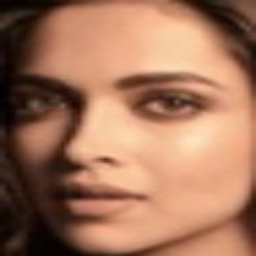

In [ ]:
x=my_sample['images'][0][0].permute(1,2,0)
y=x.numpy()
cv2_imshow(y)


In [ ]:
my_loss, my_output = model.set_forward_loss(my_sample)

In [ ]:
my_output

{'acc': 0.19999998807907104, 'loss': 1008.6615600585938, 'y_hat': tensor([[4],
         [0],
         [1],
         [3],
         [4]], device='cuda:0')}

In [ ]:
output_numpy=my_output['y_hat'].cpu().numpy()

In [ ]:
output_numpy

array([[4],
       [0],
       [1],
       [3],
       [4]])

In [ ]:
output=output_numpy.tolist()
output

[[4], [0], [1], [3], [4]]

In [ ]:
from collections import Counter


In [ ]:
final_outputs=[]
for i in range(len(output)):
  x=Counter(output[i])
  t=max(x.values())
  for item in x:
    if x[item]==t:
      final_outputs.append(item)
      break
final_outputs

[4, 0, 1, 3, 4]

In [ ]:
result=0
for i in range(len(final_outputs)):
  if final_outputs[i]==i:
    result+=1
accuracy=result/len(final_outputs)

In [ ]:
accuracy

0.4

In [ ]:
%%time
def monte_carlo(nw,ns,nq,iters=10000):
  accuracy_list=[]
  for p in range(iters):
    n_way =nw
    n_support = ns
    n_query =nq
    test_x = testx
    test_y = testy
    my_sample = extract_test_sample(n_way, n_support, n_query, test_x, test_y)
    my_loss, my_output = model.set_forward_loss(my_sample)
    output_numpy=my_output['y_hat'].cpu().numpy()
    output=output_numpy.tolist()
    final_outputs=[]
    for i in range(len(output)):
      x=Counter(output[i])
      t=max(x.values())
      for item in x:
        if x[item]==t:
          final_outputs.append(item)
          break
    result=0
    for i in range(len(final_outputs)):
      if final_outputs[i]==i:
        result+=1
    accuracy=result/len(final_outputs)
    accuracy_list.append(accuracy)
  answer=sum(accuracy_list)/len(accuracy_list)
  return answer
w=monte_carlo(5,1,1,100000)  

CPU times: user 56min 16s, sys: 24.4 s, total: 56min 40s
Wall time: 56min 25s


In [ ]:
w

0.4250860000005973

In [ ]:
dsfsdfcdf

In [ ]:
efesf

In [ ]:
dzsefdd